In [1]:
import pandas as pd
import numpy as np
import math  
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option("display.max_columns",300)

In [3]:
data =  pd.read_csv(r'../data/final-features.csv', sep=';')
data.shape

(50796, 252)

In [4]:
data.sample(5)

,index,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,has_availability,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,first_review_days,last_review_days,host_since_days,calendar_last_scraped_days,host_response_time_ordinal,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,cancellation_policy_ordinal,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Bus,property_type_Cabin,property_type_Camper/RV,property_type_Casa particular (Cuba),property_type_Castle,property_type_Cave,property_type_Condominium,property_type_Cottage,property_type_Dome house,property_type_Dorm,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Houseboat,property_type_In-law,property_type_Island,property_type_Lighthouse,property_type_Loft,property_type_Other,property_type_Resort,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tiny house,property_type_Townhouse,property_type_Train,property_type_Treehouse,property_type_Villa,property_type_Yurt,listing_duration,hosting_duration,price_per_person,Unnamed: 104,toilet,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,Baking sheet,Barbecue utensils,Bath towel,Bathrobes,Bathroom essentials,Bathtub,Bathtub with bath chair,Beach essentials,Beachfront,Bed linens,Bedroom comforts,Bluetooth speaker,Body soap,Bottled water,Bread maker,Breakfast,Building staff,Buzzer/wireless intercom,Cable TV,Carbon monoxide detector,Cat(s),Changing table,Children’s books and toys,Children’s dinnerware,Cleaning before checkout,Coffee maker,Cooking basics,Crib,Disabled parking spot,Dishes and silverware,Dishwasher,Dog(s),Doorman,Dryer,EV charger,Electric profiling bed,Elevator,Essentials,Ethernet connection,Extra pillows and blankets,Extra space around bed,Family/kid friendly,Fire extinguisher,Fireplace guards,Firm mattress,First aid kit,Fixed grab bars for shower,Fixed grab bars for toilet,Flat path to guest entrance,Free parking on premises,Free street parking,Full kitchen,Game console,Garden or backyard,Ground floor access,Gym,Hair dryer,Handheld shower head,Hangers,Heating,High chair,Host greets you,Hot tub,Hot water,Hot water kettle,Indoor fireplace,Internet,Iron,Keypad,Kitchen,Kitchenette,Lake access,Laptop friendly workspace,Lock on bedroom door,Lockbox,Long term stays allowed,Luggage dropoff allowed,Microwave,Mini bar,Mini fridge,Mobile hoist,No stairs or steps to enter,Other,Other pet(s),Outlet covers,Oven,Pack ’n Play/travel crib,Paid parking off premises,Paid parking on premises,Patio or balcony,Pets allowed,Pets live on this property,Pocket wifi,Pool,Private bathroom,Private entrance,Private living room,Record player,Refrigerator,Room-darkening sh

## Split Data

In [5]:
X = data.drop(['price'], axis=1)
y = data.price.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(40636, 251) (40636,)
(10160, 251) (10160,)


## Normalize Data

In [6]:
norm = MaxAbsScaler()
norm = norm.fit(X_train)

X_train = norm.transform(X_train)
X_test = norm.transform(X_test)

## LightGBM

In [7]:
from lightgbm import LGBMRegressor

lgbm_model =LGBMRegressor(
    num_leaves=100,
    learning_rate=0.05,
    n_estimators=1000)

In [8]:
lgbm_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=100, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [9]:
y_pred = lgbm_model.predict(X_test)

In [10]:
r2 = metrics.r2_score(y_test, y_pred)
rmse = math.sqrt(metrics.mean_squared_error(y_test, y_pred))
mae = metrics.mean_absolute_error(y_test, y_pred)

In [11]:
lgbm_scores = pd.DataFrame({'LGBM Regression' : [r2, rmse, mae]}, index=['R2', 'RMSE', 'MAE'])
lgbm_scores

,LGBM Regression)
R2,0.988799
RMSE,40.573952
MAE,3.505292


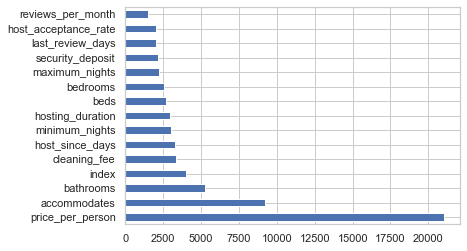

In [12]:
feat_importances = pd.Series(lgbm_model.feature_importances_, index= X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.savefig('lgbm-features-importances.png')
plt.show()

In [14]:
lgbm_scores.to_csv('../results/lgbm-scores.csv', sep=';', index=False)